Basic Tweedie stuff, relationship with Poisson and Gamma, how the parameters work, how you can move from one set to the other. 

What we usually mean by Tweedie is the compound Poisson-gamma version.

In [26]:
import numpy as np
import pandas as pd

import tweedie

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import TweedieRegressor

# Generate Sample

This is not as straightforward as it sounds. Going to use the tweedie package. https://github.com/thequackdaddy/tweedie

In [2]:
my_mu = 1000
my_sigma_sq = 20
my_p = 1.5

sample_num = 10000

In [3]:
tvs = tweedie.tweedie(mu=my_mu, phi=my_sigma_sq, p=my_p).rvs(sample_num)

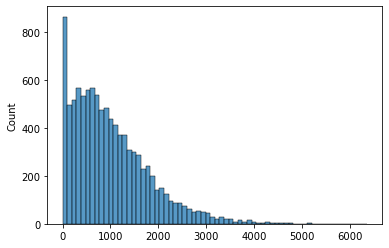

In [4]:
sns.histplot(tvs)
plt.show()

Let's check if the moments are OK. Expected value is mu, variance is sigma_sq * mu ^ p.

In [5]:
np.mean(tvs)

1007.6913833980872

In [6]:
np.math.pow(np.std(tvs),2)

645419.2476733369

In [7]:
my_sigma_sq * np.math.pow(my_mu, my_p)

632455.5320336758

OK, seems to be matching, roughly. 

# Connection w. Poisson and Gamma

Let's try and work out how these refer to the underlying Poisson and Gamma parameters. Using formulas here: 
https://en.wikipedia.org/wiki/Compound_Poisson_distribution

In [8]:
def calculate_poisson_lambda_from_tweedie(mu, sigma_sq, p):
    """
    Returns the lambda parameter of the underlying Poisson from a 1<p<2 Tweedie.
    """
    poisson_lambda = (np.math.pow(mu, (2-p))) / ((2-p) * sigma_sq)
    
    return poisson_lambda

In [9]:
poisson_lambda = calculate_poisson_lambda_from_tweedie(my_mu, my_sigma_sq, my_p)

In [10]:
poisson_lambda

3.162277660168379

We can test the Poisson lambda with 0's of original Tweedie. 

In [11]:
len(tvs[tvs==0]) / len(tvs)

0.041

In [12]:
np.math.pow(poisson_lambda, 0) * np.exp(-poisson_lambda) / 1

0.04232921962320501

Looks promising, I am not sure if we would expect a full match though...

In [13]:
def calculate_gamma_alpha_from_tweedie(p):
    """
    We only need the p parameter for this.
    """
    gamma_alpha = (2 - p) / (p - 1)
    
    return gamma_alpha

In [14]:
gamma_alpha = calculate_gamma_alpha_from_tweedie(my_p)
gamma_alpha

1.0

In [15]:
def calculate_gamma_beta_from_tweedie(mu, sigma_sq, p):

    gamma_beta = (np.math.pow(mu, (1-p))) / ((p-1) * sigma_sq)
    
    return gamma_beta

In [16]:
gamma_beta = calculate_gamma_beta_from_tweedie(my_mu, my_sigma_sq, my_p)
gamma_beta

0.003162277660168379

Note: this is the opposite parametrisation of Gamma. Basically, alpha is same as k, while beta is the reciprocal of theta in the other version. beta is the so-called rate parameter, while theta is called the scale. 

Let's see if we can do the formulas backwards. 

In [17]:
def calculate_tweedie_p_from_cpg(gamma_alpha):
    
    p = (gamma_alpha + 2) / (gamma_alpha + 1)
    
    return p

In [18]:
tweedie_p = calculate_tweedie_p_from_cpg(gamma_alpha)
tweedie_p

1.5

In [19]:
def calculate_tweedie_mu_from_cpg(poisson_lambda, gamma_alpha, gamma_beta):
    
    tweedie_p = calculate_tweedie_p_from_cpg(gamma_alpha)
    
    tweedie_mu = ((2 - tweedie_p) * poisson_lambda) / ((tweedie_p - 1) * gamma_beta)
    
    return tweedie_mu

In [20]:
tweedie_mu = calculate_tweedie_mu_from_cpg(poisson_lambda, gamma_alpha, gamma_beta)
tweedie_mu

1000.0

In [21]:
def calculate_tweedie_sigma_sq_from_cpg(poisson_lambda, gamma_alpha, gamma_beta):
    
    tweedie_p = calculate_tweedie_p_from_cpg(gamma_alpha)
    
    tweedie_mu = calculate_tweedie_mu_from_cpg(poisson_lambda, gamma_alpha, gamma_beta)
    
    tweedie_sigma_sq = (np.math.pow(tweedie_mu, (2 - tweedie_p))) / ((2 - tweedie_p) * poisson_lambda)
    
    return tweedie_sigma_sq

In [22]:
tweedie_sigma_sq = calculate_tweedie_sigma_sq_from_cpg(poisson_lambda, gamma_alpha, gamma_beta)
tweedie_sigma_sq

20.0

OK, I think we can calculate it back and forwards. 

A key result is that p depends only on the gamma distribution's shape parameter. 

__TODO__:
- get a more elegant formula here

# GLM

## Baseline

In [25]:
df = pd.DataFrame.from_dict({'target': tvs})

df['dummy_feature'] = 1

In [28]:
mdl = TweedieRegressor(power = my_p, alpha = 0)

In [32]:
mdl.fit(df[['dummy_feature']], df['target'])

TweedieRegressor(alpha=0, power=1.5)

In [33]:
df['pred'] = mdl.predict(df[['dummy_feature']])

In [35]:
df.pred[0]

1007.6913833980866

OK, it got the mu right. 

In [36]:
np.mean(tvs)

1007.6913833980872

Question: what if we mess up the power function? 

In [37]:
mdl = TweedieRegressor(power = 1.1, alpha = 0)
mdl.fit(df[['dummy_feature']], df['target'])
df['pred'] = mdl.predict(df[['dummy_feature']])
df.pred[0]

1007.6913833980866

In [38]:
mdl = TweedieRegressor(power = 1.9, alpha = 0)
mdl.fit(df[['dummy_feature']], df['target'])
df['pred'] = mdl.predict(df[['dummy_feature']])
df.pred[0]

1007.6913833980866

Yup, power parameter does not matter here!

## Linear Increase in Mu

First off, we need to find a way to generate one that depends on a continuous feature. 

In [87]:
df_mdl = pd.DataFrame.from_dict({'feature_1' : np.random.uniform(100,1000,10000)})

df_mdl['mu'] = df_mdl['feature_1']
df_mdl['sigma_sq'] = 20
df_mdl['p'] = 1.5

In [88]:
# this takes a while to run
df_mdl['total_claim_amount'] = df_mdl.apply(lambda x: tweedie.tweedie(mu=x['mu'], 
                                               phi=x['sigma_sq'], 
                                               p=x['p']).rvs(1)[0], axis = 1)

In [89]:
df_mdl['log_feature_1'] = np.log(df_mdl['feature_1'])

In [90]:
mdl = TweedieRegressor(power = 1.5, alpha = 0)
X = df_mdl[['log_feature_1']]
y = df_mdl['total_claim_amount']
mdl.fit(X, y)
df_mdl['pred_total_claim_amount'] = mdl.predict(X)

In [91]:
mdl.coef_

array([0.98321279])

Once again, what happens if we mess up the variance power? 

In [92]:
mdl = TweedieRegressor(power = 1.9, alpha = 0)
X = df_mdl[['log_feature_1']]
y = df_mdl['total_claim_amount']
mdl.fit(X, y)
df_mdl['pred_total_claim_amount_wrong_p'] = mdl.predict(X)

In [93]:
mdl.coef_

array([0.98447209])

In [94]:
df_mdl.head(5)

,feature_1,mu,sigma_sq,p,total_claim_amount,log_feature_1,pred_total_claim_amount,pred_total_claim_amount_wrong_p
0,194.463693,194.463693,20,1.5,447.104651,5.270245,197.501784,197.257261
1,499.551348,499.551348,20,1.5,385.871859,6.213710,499.383524,499.358186
2,455.940204,455.940204,20,1.5,243.061351,6.122362,456.486513,456.410844
3,251.078184,251.078184,20,1.5,84.131650,5.525764,253.909289,253.676542
4,422.556645,422.556645,20,1.5,396.830739,6.046324,423.603325,423.492554


Haha! OK, interesting, it does change the predictions. 

In [95]:
np.mean(df_mdl['total_claim_amount'])

544.5190902904887

In [96]:
np.mean(df_mdl['pred_total_claim_amount'])

544.5750699991881

In [97]:
np.mean(df_mdl['pred_total_claim_amount_wrong_p'])

544.6906777916271

## Linear Increase in P

In [98]:
df_mdl = pd.DataFrame.from_dict({'feature_1' : np.random.uniform(1.01, 1.99,10000)})

df_mdl['mu'] = 1000
df_mdl['sigma_sq'] = 20
df_mdl['p'] =  df_mdl['feature_1']

In [99]:
# this takes a while to run
df_mdl['total_claim_amount'] = df_mdl.apply(lambda x: tweedie.tweedie(mu=x['mu'], 
                                               phi=x['sigma_sq'], 
                                               p=x['p']).rvs(1)[0], axis = 1)

In [100]:
df_mdl['log_feature_1'] = np.log(df_mdl['feature_1'])

In [101]:
mdl = TweedieRegressor(power = 1.5, alpha = 0)
X = df_mdl[['log_feature_1']]
y = df_mdl['total_claim_amount']
mdl.fit(X, y)
df_mdl['pred_total_claim_amount'] = mdl.predict(X)

In [102]:
mdl.coef_

array([-0.14049549])

In [104]:
df_mdl.head(5)

,feature_1,mu,sigma_sq,p,total_claim_amount,log_feature_1,pred_total_claim_amount
0,1.535445,1000,20,1.535445,441.225595,0.428820,981.412763
1,1.194578,1000,20,1.194578,718.411364,0.177793,1016.643045
2,1.552355,1000,20,1.552355,838.059466,0.439773,979.903686
3,1.058246,1000,20,1.058246,946.195624,0.056613,1034.099766
4,1.692153,1000,20,1.692153,698.421832,0.526002,968.104022


In [105]:
np.mean(df_mdl['total_claim_amount'])

987.382983319981

In [106]:
np.mean(df_mdl['pred_total_claim_amount'])

987.3854885632887

OK, that's good, so it does find stuff where there's nothing. 

In [116]:
mdl = TweedieRegressor(power = 1.5, alpha = 0)
X = df_mdl[['log_feature_1']]
y = df_mdl['total_claim_amount']
mdl.fit(X, y)
df_mdl['pred_total_claim_amount'] = mdl.predict(X)

In [117]:
mdl.coef_

array([-0.14049549])

In [118]:
df_mdl.head(5)

,feature_1,mu,sigma_sq,p,total_claim_amount,log_feature_1,pred_total_claim_amount
0,1.535445,1000,20,1.535445,441.225595,0.428820,981.412763
1,1.194578,1000,20,1.194578,718.411364,0.177793,1016.643045
2,1.552355,1000,20,1.552355,838.059466,0.439773,979.903686
3,1.058246,1000,20,1.058246,946.195624,0.056613,1034.099766
4,1.692153,1000,20,1.692153,698.421832,0.526002,968.104022
